# Word2Vec Scratch

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns  
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("darkgrid")

import pickle
from collections import defaultdict
import multiprocessing

import gensim
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from preprocessing_funcs import clean_tweet, get_hashtags, hashtag_dict

TEST

In [2]:
documents = ["Will this work?  I'm not sure.  If not go to step #4 (above)"]
texts = [[word for word in document.lower().split()]
         for document in documents]


print (texts)
model = gensim.models.Word2Vec(texts, size=100, window=5, min_count=1, workers=2,sg=1)

[['will', 'this', 'work?', "i'm", 'not', 'sure.', 'if', 'not', 'go', 'to', 'step', '#4', '(above)']]


## Data Import

In [3]:
with open('../data_files/processed_tweets.pickle', 'rb') as read_file:
    df = pickle.load(read_file)

In [4]:
df = df[['text']]

In [5]:
df['clean'] = df['text'].map(clean_tweet)

In [6]:
df['clean'] = df['clean'].replace(hashtag_dict, regex=True)

In [7]:
df.head()

,text,clean
0,#IslamKills Are you trying to say that there w...,islam kills are you trying to say that there w...
1,"Clinton: Trump should’ve apologized more, atta...",clinton trump should ve apologized more attack...
2,RT @ltapoll: Who was/is the best president of ...,who was is the best president of the past year...
3,RT @jww372: I don't have to guess your religio...,i don t have to guess your religion christmas ...
4,RT @Shareblue: Pence and his lawyers decided w...,pence and his lawyers decided which of his off...


In [ ]:
# with open('../data_files/stopwords_eng_germ.txt') as f:
#     words = f.read().split(',')
#     stopwords = list(words)
#     stopwords = [word.lower() for word in stopwords]

# len(stopwords)

In [ ]:
# tweets = list(df.clean)

In [ ]:
# texts = [[word for word in tweet.lower().split() if word not in stopwords]
#          for tweet in tweets]

# Modeling

Following the steps laid out in this [SUPER GREAT TUTORIAL](https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial)

In [8]:
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

## Hunting for bigrams

In [9]:
# bigram
sent = [row.split() for row in df['clean']]

In [10]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

INFO - 16:26:12: collecting all words and their counts
INFO - 16:26:12: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 16:26:12: PROGRESS: at sentence #10000, processed 125797 words and 92755 word types
INFO - 16:26:12: PROGRESS: at sentence #20000, processed 252943 words and 160726 word types
INFO - 16:26:12: PROGRESS: at sentence #30000, processed 379351 words and 219152 word types
INFO - 16:26:12: PROGRESS: at sentence #40000, processed 504580 words and 271500 word types
INFO - 16:26:13: PROGRESS: at sentence #50000, processed 629467 words and 319871 word types
INFO - 16:26:13: PROGRESS: at sentence #60000, processed 755891 words and 365137 word types
INFO - 16:26:13: PROGRESS: at sentence #70000, processed 881800 words and 408208 word types
INFO - 16:26:13: PROGRESS: at sentence #80000, processed 1008209 words and 449751 word types
INFO - 16:26:13: PROGRESS: at sentence #90000, processed 1133724 words and 488880 word types
INFO - 16:26:14: PROGRESS: at sentence

In [11]:
bigram = Phraser(phrases)

INFO - 16:26:22: source_vocab length 851223
INFO - 16:26:27: Phraser built with 1015 phrasegrams


In [12]:
sentences = bigram[sent]

## Most frequent words

In [13]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

92629

In [14]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['the', 'to', 'a', 'in', 'trump', 's', 'of', 'is', 'and', 'for']

## Training the model

3 phases: 
1. `Word2Vec()`
2. `.build_vocab()`
3. `.train`

In [15]:
cores = multiprocessing.cpu_count()
cores

12

### Initialize Model

In [16]:
w2v_model = Word2Vec(min_count=20,
                     window=4,
                     size=200,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=100,
                     workers=cores-1)

### Build Vocabulary

In [18]:
from time import time 

In [19]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 16:28:40: collecting all words and their counts
INFO - 16:28:40: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 16:28:40: PROGRESS: at sentence #10000, processed 117053 words, keeping 18644 word types
INFO - 16:28:41: PROGRESS: at sentence #20000, processed 235524 words, keeping 27565 word types
INFO - 16:28:41: PROGRESS: at sentence #30000, processed 353054 words, keeping 34415 word types
INFO - 16:28:41: PROGRESS: at sentence #40000, processed 469613 words, keeping 40051 word types
INFO - 16:28:41: PROGRESS: at sentence #50000, processed 585912 words, keeping 45125 word types
INFO - 16:28:42: PROGRESS: at sentence #60000, processed 703449 words, keeping 49637 word types
INFO - 16:28:42: PROGRESS: at sentence #70000, processed 820430 words, keeping 53842 word types
INFO - 16:28:42: PROGRESS: at sentence #80000, processed 938065 words, keeping 57776 word types
INFO - 16:28:42: PROGRESS: at sentence #90000, processed 1054811 words, keeping 61432 word typ

Time to build vocab: 0.11 mins


### Training of the Model

In [20]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 16:29:24: training model with 11 workers on 9716 vocabulary and 100 features, using sg=0 hs=0 sample=6e-05 negative=100 window=2
INFO - 16:29:25: EPOCH 1 - PROGRESS: at 16.71% examples, 179670 words/s, in_qsize 0, out_qsize 0
INFO - 16:29:26: EPOCH 1 - PROGRESS: at 36.47% examples, 173650 words/s, in_qsize 0, out_qsize 0
INFO - 16:29:27: EPOCH 1 - PROGRESS: at 52.38% examples, 173062 words/s, in_qsize 0, out_qsize 0
INFO - 16:29:28: EPOCH 1 - PROGRESS: at 69.57% examples, 175754 words/s, in_qsize 1, out_qsize 0
INFO - 16:29:29: EPOCH 1 - PROGRESS: at 85.49% examples, 173840 words/s, in_qsize 0, out_qsize 0
INFO - 16:29:30: worker thread finished; awaiting finish of 10 more threads
INFO - 16:29:30: worker thread finished; awaiting finish of 9 more threads
INFO - 16:29:30: worker thread finished; awaiting finish of 8 more threads
INFO - 16:29:30: worker thread finished; awaiting finish of 7 more threads
INFO - 16:29:30: worker thread finished; awaiting finish of 6 more threads
INF

INFO - 16:30:01: worker thread finished; awaiting finish of 8 more threads
INFO - 16:30:01: worker thread finished; awaiting finish of 7 more threads
INFO - 16:30:01: worker thread finished; awaiting finish of 6 more threads
INFO - 16:30:01: worker thread finished; awaiting finish of 5 more threads
INFO - 16:30:01: worker thread finished; awaiting finish of 4 more threads
INFO - 16:30:01: worker thread finished; awaiting finish of 3 more threads
INFO - 16:30:01: worker thread finished; awaiting finish of 2 more threads
INFO - 16:30:01: worker thread finished; awaiting finish of 1 more threads
INFO - 16:30:01: worker thread finished; awaiting finish of 0 more threads
INFO - 16:30:01: EPOCH - 6 : training on 2386068 raw words (1083911 effective words) took 6.4s, 170601 effective words/s
INFO - 16:30:02: EPOCH 7 - PROGRESS: at 17.12% examples, 184590 words/s, in_qsize 0, out_qsize 0
INFO - 16:30:03: EPOCH 7 - PROGRESS: at 33.52% examples, 179253 words/s, in_qsize 0, out_qsize 0
INFO - 16:

INFO - 16:30:33: EPOCH 12 - PROGRESS: at 55.73% examples, 197392 words/s, in_qsize 0, out_qsize 0
INFO - 16:30:34: EPOCH 12 - PROGRESS: at 70.41% examples, 186948 words/s, in_qsize 0, out_qsize 2
INFO - 16:30:35: EPOCH 12 - PROGRESS: at 88.38% examples, 188232 words/s, in_qsize 0, out_qsize 2
INFO - 16:30:36: worker thread finished; awaiting finish of 10 more threads
INFO - 16:30:36: worker thread finished; awaiting finish of 9 more threads
INFO - 16:30:36: worker thread finished; awaiting finish of 8 more threads
INFO - 16:30:36: worker thread finished; awaiting finish of 7 more threads
INFO - 16:30:36: worker thread finished; awaiting finish of 6 more threads
INFO - 16:30:36: worker thread finished; awaiting finish of 5 more threads
INFO - 16:30:36: worker thread finished; awaiting finish of 4 more threads
INFO - 16:30:36: worker thread finished; awaiting finish of 3 more threads
INFO - 16:30:36: worker thread finished; awaiting finish of 2 more threads
INFO - 16:30:36: worker thread

INFO - 16:31:06: worker thread finished; awaiting finish of 4 more threads
INFO - 16:31:06: worker thread finished; awaiting finish of 3 more threads
INFO - 16:31:06: worker thread finished; awaiting finish of 2 more threads
INFO - 16:31:06: worker thread finished; awaiting finish of 1 more threads
INFO - 16:31:06: worker thread finished; awaiting finish of 0 more threads
INFO - 16:31:06: EPOCH - 17 : training on 2386068 raw words (1084020 effective words) took 5.7s, 189447 effective words/s
INFO - 16:31:07: EPOCH 18 - PROGRESS: at 15.02% examples, 160434 words/s, in_qsize 0, out_qsize 0
INFO - 16:31:08: EPOCH 18 - PROGRESS: at 28.89% examples, 154946 words/s, in_qsize 0, out_qsize 0
INFO - 16:31:09: EPOCH 18 - PROGRESS: at 45.25% examples, 161449 words/s, in_qsize 0, out_qsize 0
INFO - 16:31:10: EPOCH 18 - PROGRESS: at 55.73% examples, 148071 words/s, in_qsize 0, out_qsize 0
INFO - 16:31:11: EPOCH 18 - PROGRESS: at 70.41% examples, 149726 words/s, in_qsize 0, out_qsize 0
INFO - 16:31:

Time to train the model: 2.02 mins


In [22]:
w2v_model.wv.most_similar(positive=["trump"], topn=15)

[('donald_trump', 0.807303249835968),
 ('real_donald', 0.7025585174560547),
 ('hillary_clinton', 0.586850106716156),
 ('donaldtrump', 0.5796821713447571),
 ('hillary', 0.5689446926116943),
 ('clinton', 0.5564097762107849),
 ('mike_pence', 0.5253126621246338),
 ('christie', 0.5230844020843506),
 ('newhampshire', 0.5213742852210999),
 ('trumps', 0.5186635255813599),
 ('pence', 0.5147822499275208),
 ('trumpwinsbecause', 0.5140880346298218),
 ('president_elect', 0.5078293681144714),
 ('trumppence', 0.5058931112289429),
 ('djt', 0.5015503168106079)]

In [23]:
w2v_model.wv.most_similar(positive=["clinton"], topn=15)

[('hillary_clinton', 0.7689953446388245),
 ('hillary', 0.6878668069839478),
 ('campaign', 0.6196262240409851),
 ('huma_abedin', 0.594873309135437),
 ('politics_extra', 0.5899741649627686),
 ('foke', 0.5828642845153809),
 ('sanders', 0.5779204368591309),
 ('email_scandal', 0.5696285963058472),
 ('clinton_camp', 0.5622636675834656),
 ('trump', 0.5564098954200745),
 ('bill_clinton', 0.5454525351524353),
 ('via_conservativebyt', 0.5436488389968872),
 ('state_department', 0.5385733842849731),
 ('christie', 0.5381031632423401),
 ('donald_trump', 0.5327397584915161)]

In [26]:
w2v_model.wv.doesnt_match(['trump', 'clinton', 'isis'])

/Users/scrapfish/opt/anaconda3/envs/metis/lib/python3.8/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'isis'

In [27]:
w2v_model.wv.most_similar(positive=["man", "clinton"], negative=["trump"], topn=3)

[('woman', 0.5974641442298889),
 ('girl', 0.49575376510620117),
 ('brutally', 0.4905543029308319)]

In [28]:
w2v_model.wv.most_similar(positive=["woman", "obama"], negative=["man"], topn=3)

[('john_kerry', 0.5594840049743652),
 ('hillary_clinton', 0.540998101234436),
 ('hillary', 0.5308032035827637)]

## Visualizations

In [39]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA 
    # (might need to reduce to 19 or 10?)
    reduc = PCA(n_components=19).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

### 10 Most Similar Words vs. 8 Random Words

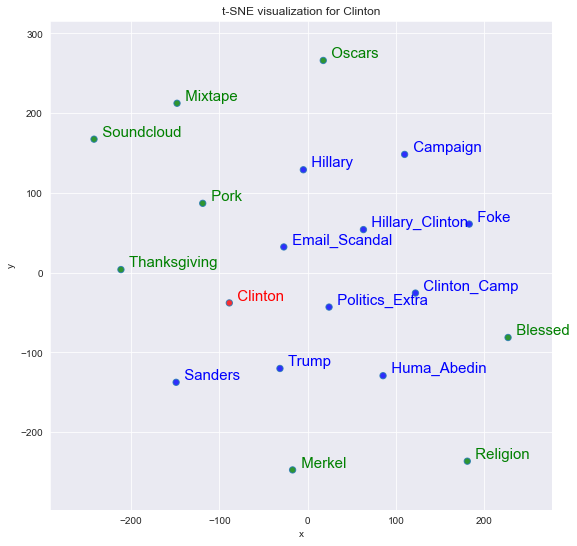

In [45]:
tsnescatterplot(w2v_model, 'clinton', ['soundcloud', 'mixtape', 'merkel', 'blessed', 
                                       'pork', 'thanksgiving', 'oscars', 'religion'])

### 10 Most Similar Words vs. 10 Most Dissimilar

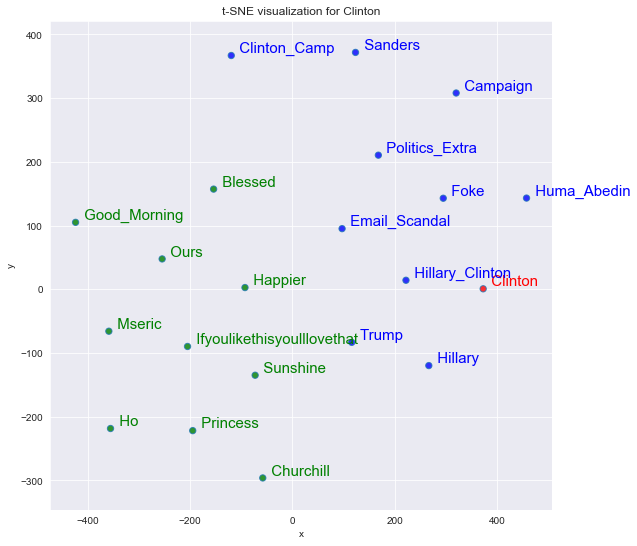

In [40]:
tsnescatterplot(w2v_model, 'clinton', [i[0] for i in w2v_model.wv.most_similar(negative=["clinton"])])

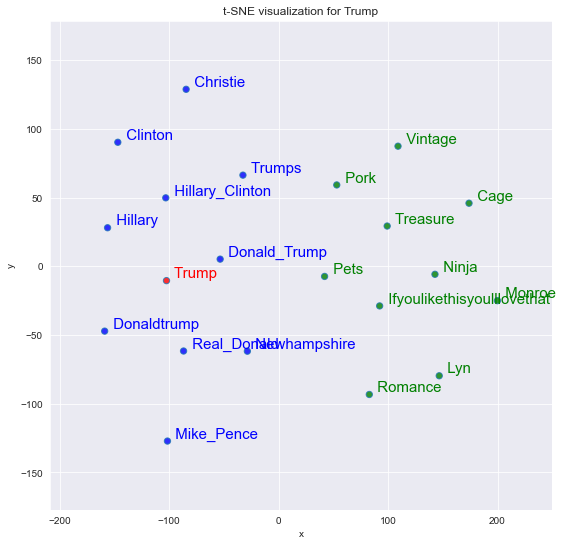

In [41]:
tsnescatterplot(w2v_model, 'trump', [i[0] for i in w2v_model.wv.most_similar(negative=["trump"])])

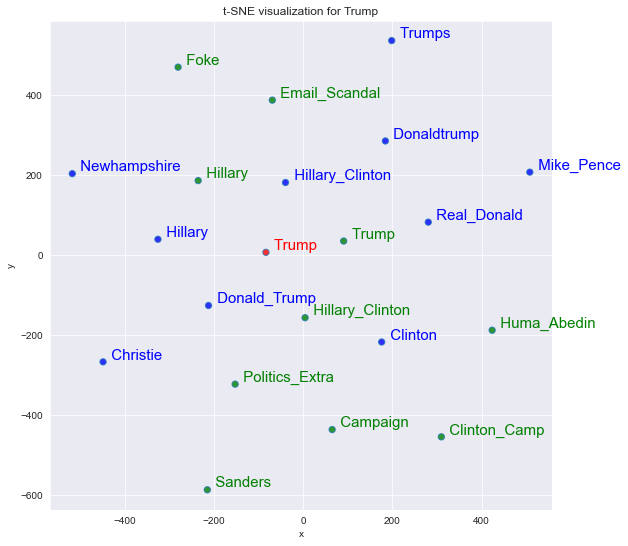

In [42]:
tsnescatterplot(w2v_model, 'trump', [i[0] for i in w2v_model.wv.most_similar(positive=["clinton"])])

### 10 Most similar words vs. 11th to 20th Most similar words

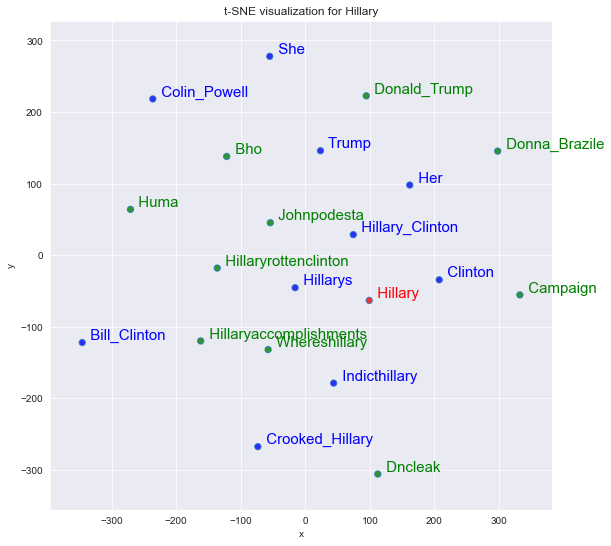

In [46]:
tsnescatterplot(w2v_model, "hillary", 
                [t[0] for t in w2v_model.wv.most_similar(positive=["hillary"], topn=20)][10:])

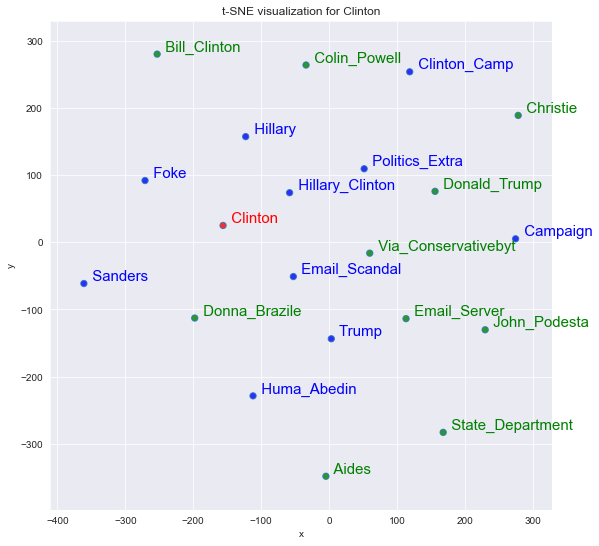

In [47]:
tsnescatterplot(w2v_model, "clinton", 
                [t[0] for t in w2v_model.wv.most_similar(positive=["clinton"], topn=20)][10:])

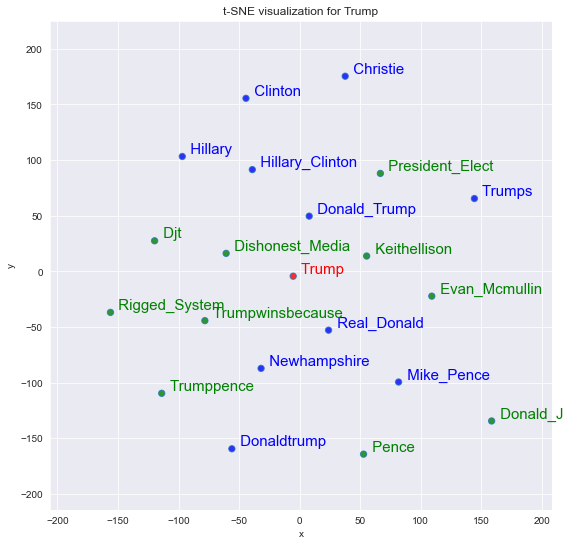

In [48]:
tsnescatterplot(w2v_model, "trump", 
                [t[0] for t in w2v_model.wv.most_similar(positive=["trump"], topn=20)][10:])

## Saving the model

No more training - using `init_sims()` to make the model more memory efficient

In [ ]:
# w2v_model.init_sims(replace=True)

In [ ]:
# w2v_model.save("w2v.model")

In [ ]:
# to load
# model = gensim.models.Word2Vec.load("w2v.model")